# Introduction to PyTorch

In this second lab of the **ErSE 222 - Machine Learning in Geoscience** course, we will start to familiarize ourselves with PyTorch and use it to:

- find the mimimum of a the *Rosenbrock function*. This function, also known as Rosenbrock's valley or Rosenbrock's banana function, is a non-convex function introduced by Howard H. Rosenbrock in 1960 used as a performance test problem for optimization algorithms;
- implement our first feed-forward neural network for a classification problem.

This notebook is heavily inspired from the material prepared by Lukas Mosser some years ago for a one-day Introduction to PyTorch at the LondonHack2019 event. Feel free to take a look at [Lukas' repository](https://github.com/LukasMosser/londonhack_pytorch) and play with the other notebooks provided in there.

## What is PyTorch?

[PyTorch](https://www.pytorch.org) is a one of the most popular Python frameworks for Machine Learning. Its developement started in 2016 at Facebook and it is heavily based on previous experience from Torch, which is based on the Lua programming language. See this [blog post](https://alexmoltzau.medium.com/pytorch-governance-and-history-2e5889b79dc1) more details about the history of Pytorch.

If you are already familiar with Python, you can think of PyTorch as an (almost) drop-in replacement to NumPy with added automatic differentiation (AD) capabilities. This means that we can write a piece of code that evaluates a chain of operations (e.g., deep neural networks) and we get derivatives for free via back-propagation.

## What is PyTorch useful for?

PyTorch is definitely useful for Machine Learning, and more specifically for Deep Learning. As we will see it comes with a lot of already implemented building blocks for creating modern deep learning architectures (e.g., linear layer, convolutional layer, recurrent layer, etc.) as well as state of the art optimizers (e.g., SDG, RMSProp, Adam, etc.). It can however be used also in a more generic context, every time we wish to optimize a non-convex functional by means of gradient-descent optimization. We will see an example of this today.

## Is there any alternative to PyTorch?
The answer is yes. You may have heard of [TensorFlow](http://tensorflow.org) before. Developed by Google, TensorFlow is also a Python framework for machine learning. Although Tensorflow and PyTorch differ a bit in the way they keep track of the computational graph and compute derivatives (if you are interested to know more, see section [6.5.5](https://www.deeplearningbook.org/contents/mlp.html) our of reference book), they are very similar in terms of functionalities and usage. 

Moreover, Tensorflow comes with a more high-level API called [Keras](https://www.tensorflow.org/guide/keras/sequential_model). This is a very useful and nice to use feature of TensorFlow for users that know what they are doing as it allows to reduce the amount of boilerplate code to the minimum and focus on actual experimentation. However, it is the risk as any other high-level API that users that do not know what they are doing will still get some results out and will likely misinterpret them. A similar API for the [PyTorch] framework exists under the name of [PyTorch-Lightning](https://pytorchlightning.ai). Although I highly reccomend taking a look at it, I discourage its use during this course until you feel very confident you understand what is happening under the hood when you create and optimize a ML model.

In [1]:
%matplotlib inline

import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import scooby

from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_moons
from sklearn.metrics import accuracy_score
from torch.utils.data import TensorDataset, DataLoader 
from torchsummary import summary

In [2]:
def set_seed(seed):
    """Set all random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled   = False

    return True

## PyTorch library structure

To begin with it is important to familiarize with PyTorch basic functionalities: 

- [torch.Tensor](https://pytorch.org/docs/stable/tensors.html): Fundamental Tensor operations (matmul, sum, mean, transpose, ...). This is the equivalent of a NumPy array.
- [torch.nn](https://pytorch.org/docs/stable/nn.html): Specialised functions for implementing (deep) neural networks
    - [Linear Layers](https://pytorch.org/docs/stable/nn.html#linear-layers)
    - [Convolutional Layers](https://pytorch.org/docs/stable/nn.html#convolution-layers)
    - [Activation Functions](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity): Sigmoid, Tanh, ReLU, ...
    - [Loss Functions](https://pytorch.org/docs/stable/nn.html#loss-functions): MSE-Loss, CrossEntropyLoss, ...
- [torch.optim](https://pytorch.org/docs/stable/optim.html): First and Second-order Gradient Descent Optimizers
- [torch.autograd](https://pytorch.org/docs/stable/autograd.html): Automatic Differentiation Functionality
- [torch.distributions](https://pytorch.org/docs/stable/distributions.html): Probability Distributions
- [torch.utils](): Utility functions
    - [torch.utils.data](https://pytorch.org/docs/stable/data.html): Contains useful methods to load and handle data
- [torchvision](https://pytorch.org/docs/stable/torchvision/index.html): Datasets, Pre-trained Models, Transforms

And remember, the best place to find more details about any of PyTorch's functionalities is its [official documentation](https://www.pytorch.org).

### Basic PyTorch Tensor operations

In [3]:
#Setting the random seed of torch, numpy and python's random module
set_seed(42)

# Define a scalar value
a = torch.tensor(5)
print(f'a: {a} {type(a)}')
print(f'a converted to scalar: {a.item()} {type(a.item())}')

# Define an array (1D Tensor)
b = torch.ones(10)
print(f'b: {b} {type(b)}')

# Define a Tensor-like another tensor - creates tensor of the same shape
c = torch.zeros_like(b)
print(f'c: {c} {type(c)}')

# Define a matrix (2D Tensor)
d = torch.ones((2, 2))
print(f'd: {d} {type(d)} {d.shape}')

# Create a torch.Tensor from a numpy array
e = torch.from_numpy(np.array(range(4))) 
print(f'e: {e} {type(e)}')

# Get back the underlying numpy array
print(f'e to numpy: {e.numpy()} {type(e.numpy())}')

a: 5 <class 'torch.Tensor'>
a converted to scalar: 5 <class 'int'>
b: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]) <class 'torch.Tensor'>
c: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]) <class 'torch.Tensor'>
d: tensor([[1., 1.],
        [1., 1.]]) <class 'torch.Tensor'> torch.Size([2, 2])
e: tensor([0, 1, 2, 3]) <class 'torch.Tensor'>
e to numpy: [0 1 2 3] <class 'numpy.ndarray'>


In [4]:
# Create a Tensor that we later want to differentiate
b = torch.ones(10, requires_grad=True)
print(f'b: {b} {type(b)}')

# Get back the underlying numpy array
print(f'b to numpy: {b.detach().numpy()} {type(b.detach().numpy())}')

b: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], requires_grad=True) <class 'torch.Tensor'>
b to numpy: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] <class 'numpy.ndarray'>


In [5]:
# Create a tensor of Gaussian (0-mean, 1-std. dev.) values
m = torch.randn(1, 1, 28, 28)

print(f'size of m {m.size()}')
print(f'mean and std of m: {torch.mean(m)}, {torch.std(m)}')

size of m torch.Size([1, 1, 28, 28])
mean and std of m: 0.02346729300916195, 1.0006682872772217


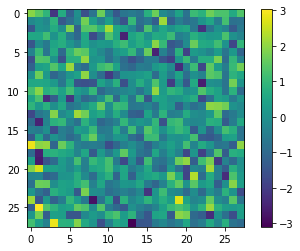

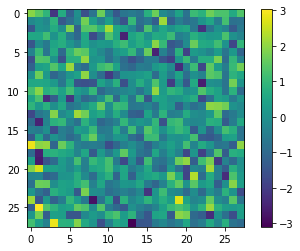

In [6]:
# Plotting Pytorch Tensors (automatically handled by matplotlib)
plt.figure()
plt.imshow(m[0, 0])
plt.colorbar();

plt.figure()
plt.imshow(m.detach()[0, 0])
plt.colorbar();

### Using a GPU
PyTorch also provides a GPU backend. Provided we have access to a GPU, let's see how we can move our tensors from the CPU to the GPU and back

In [7]:
# Little boilerplate code to find out if we have a gpu
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")
print(f'Device: {device}')

No GPU available!
Device: cpu


In [8]:
# Move a tensor around using the .to(device) command
tensor_on_device = torch.ones(1).to(device)
print(tensor_on_device.device)

# Explicitely move tensor back to cpu
tensor_on_cpu = tensor_on_device.cpu()
print(tensor_on_cpu.device)

cpu
cpu


### Pytorch Autograd

With PyTorch you can write any sequence of operations on a Tensor. As long as these are all PyTorch operations, PyTorch will create a computational graph which we can always traverse back to obtain the derivative of such a sequence of operations.

Let's consider the following function:
$$
f(x) = sin(\pi x)
$$

We know that its derivative is:

$$
f'(x) = \pi cos(\pi x)
$$

So for $x=1$, we should expect $f(x)=0$ and $f'(x) = -\pi$.

In [9]:
x = torch.ones(1, requires_grad=True)
y = torch.sin(x * np.pi)

print(f'x: {x.item()}, y:{y.item()}')
print(f'The derivative of y is: {torch.autograd.grad(y, x)[0].item()}')

x: 1.0, y:-8.742277657347586e-08
The derivative of y is: -3.1415927410125732


Or in many cases we may want to put our operation in a function

In [10]:
def f(x):
    return torch.sin(x * np.pi)

x = torch.ones(1, requires_grad=True)
y = f(x)

print(f'x: {x.item()}, y:{y.item()}')
print(f'The derivative of y is: {torch.autograd.grad(y, x)[0].item()}')

x: 1.0, y:-8.742277657347586e-08
The derivative of y is: -3.1415927410125732


### Pytorch Modules

Modules are a very powerful constuct in PyTorch. They are classes composed of two methods:

- `__init__`: where we can instatiate a number of parameters we wish our computational graph to be able to differentiate for;
- `forward`: where we write the actual expression we want to compute (our f(x) in previous cell).

Let's define a parabola:

$$
f(a, b) = a x^2 + b
$$

The derivatives with respect to $a$ and $b$ are:

$$
df/da = x^2, \; df/db = 1
$$

which means indipendently of $a$ and $b$, if we choose $x=4$ we should expect:

$$
df/da = 16, \; df/db = 1
$$

In [11]:
class ParametricParabola(nn.Module):
    def __init__(self, a, b):
        super().__init__()
        self.a = torch.nn.Parameter(a * torch.ones(1))
        self.b = torch.nn.Parameter(b * torch.ones(1))
    
    def forward(self, x):
        return self.a * x ** 2 + self.b

Let's inspect what the parameters are:

In [12]:
f = ParametricParabola(0.5, 2)
print(f.a)
print(f.b)

Parameter containing:
tensor([0.5000], requires_grad=True)
Parameter containing:
tensor([2.], requires_grad=True)


We can also compute gradients for this example with respect to the parameters:

In [13]:
# Reset all the gradients within the computational graph (always reccomended!)
f.zero_grad() 
print(f'Initial df/da: {f.a.grad}, df/db: {f.b.grad}')

# Compute forward
x = 4 * torch.ones(1, requires_grad=False)
y = f(x)

# Call autograd to compute all partial derivatives with respect to all Parameters that require gradients
y.backward() 

print(f'Computed df/da: {f.a.grad.item()}, df/db: {f.b.grad.item()}')

# Reset all the gradients within the computational graph.
f.zero_grad() 
print(f'Zeroed df/da: {f.a.grad.item()}, df/db: {f.b.grad.item()}')

Initial df/da: None, df/db: None
Computed df/da: 16.0, df/db: 1.0
Zeroed df/da: 0.0, df/db: 0.0


### PyTorch's Optimization functionality

Let's now fix $a$ and $b$ and try to find the mimimum of the parabola. Of course we can do this analytically but to start familiarizing with PyTorch's optimization functionality we will methods from ```torch.optim```.

In [14]:
set_seed(42)
x = torch.tensor(50.)
x.requires_grad = True # make sure we compute the gradient with respect to x
print(f'Initial x {x.item()}')

f = ParametricParabola(2., 0.)
f.a.requires_grad = False # make sure we don't compute the gradient with respect to x
f.b.requires_grad = False # make sure we don't compute the gradient with respect to x
print(f.a, f.b)

# Optimization
optimizer = torch.optim.SGD([x], lr=1e-3)
for i in range(3000):
    optimizer.zero_grad()
    value = f(x)
    value.backward()
    optimizer.step()
    if i % 100 == 99:
        print(f'Iteration {i}, Functional value: {value.item():.5f}, X estimate: {x.item():.5f}')

Initial x 50.0
Parameter containing:
tensor([2.]) Parameter containing:
tensor([0.])
Iteration 99, Functional value: 2261.09399, X estimate: 33.48911
Iteration 199, Functional value: 1014.34656, X estimate: 22.43043
Iteration 299, Functional value: 455.04459, X estimate: 15.02351
Iteration 399, Functional value: 204.13696, X estimate: 10.06248
Iteration 499, Functional value: 91.57767, X estimate: 6.73968
Iteration 599, Functional value: 41.08252, X estimate: 4.51412
Iteration 699, Functional value: 18.42998, X estimate: 3.02348
Iteration 799, Functional value: 8.26785, X estimate: 2.02507
Iteration 899, Functional value: 3.70903, X estimate: 1.35636
Iteration 999, Functional value: 1.66390, X estimate: 0.90846
Iteration 1099, Functional value: 0.74644, X estimate: 0.60847
Iteration 1199, Functional value: 0.33486, X estimate: 0.40755
Iteration 1299, Functional value: 0.15022, X estimate: 0.27297
Iteration 1399, Functional value: 0.06739, X estimate: 0.18283
Iteration 1499, Functional 

## Minimize the Rosenbrock function

The [Rosenbrock](https://en.wikipedia.org/wiki/Rosenbrock_function) function is a common test problem for optimization algorithms. It is written as:
$$
f(x, y)= (a-x)^2 + b(y-x^2)^2 \quad a=1,b=10
$$

In the following we will use PyTorch to evaluate this function numerically and evaluate how different PyTorch optimization methods perform in finding its global mimimum. Such minimium lies inside a long, narrow, parabolic shaped flat valley. Finding the valley is trivial, but converging to the global minimum is difficult.

Let's start by defining the function with NumPy and display it

In [15]:
def rosenbrock(x, y):
    a, b = 1, 10
    f = (a - x)**2 + b *(y - x**2)**2
    return f

In [16]:
def surf_rosenbrock(x, y):
    fig = plt.figure(figsize=(12, 7))
    ax = fig.add_subplot(projection='3d')
    
    # Make the function
    x, y = np.meshgrid(x, y)
    z = rosenbrock(x, y)

    # Plot the surface.
    surf = ax.plot_surface(x, y, z, cmap='gist_heat_r', 
                           linewidth=0, antialiased=False)

    ax.set_zlim(0, 200)
    fig.colorbar(surf, shrink=0.5, aspect=10)
    return fig, ax


def contour_rosenbrock(x, y):
    fig = plt.figure(figsize=(14, 7))
    ax = fig.add_subplot(projection='3d')
    
    # Make the function
    x, y = np.meshgrid(x, y)
    z = rosenbrock(x, y)

    # Plot the surface.
    surf = ax.contour(x, y, z, 200, cmap='gist_heat_r', vmin=-20, vmax=200,
                      linewidth=0, antialiased=False)
    fig.colorbar(surf, shrink=0.5, aspect=10)
    return fig, ax

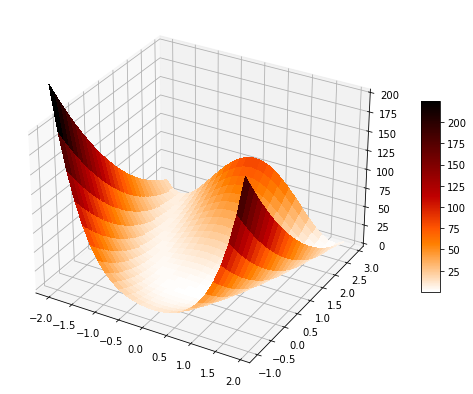

In [17]:
x = np.arange(-2, 2, 0.15)
y = np.arange(-1, 3, 0.15)
surf_rosenbrock(x, y);

Let's try now to optimize this function with PyTorch. We will proceed as follows:

- Define the Rosenbrock function as a pytorch `nn.Module` class
- Try to find the global minimum with Gradient Descent (```torch.optim.SGD```) from a selected starting position. 
- Plot the corresponding function value as a function of the iteration number 
- Plot the norm of the gradients during optimization.
- For 10 random starting positions plot the optimization trajectories together:
    - Can we always reach a global minimum?
    - What can we you observe for the various optimization trajectories.
    

In [18]:
class Rosenbrock(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, coords):
        a, b = 1, 10
        x = coords[:, 0]
        y = coords[:, 1]
        f = (a - x)**2 + b *(y - x**2)**2
        return f

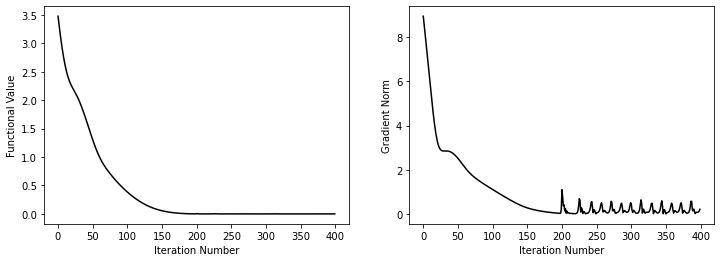

In [19]:
rosenbrock_torch = Rosenbrock()

coords = np.array([-.25, .5]).reshape(1, 2)
coords = torch.from_numpy(coords)
coords.requires_grad = True
optimizer = torch.optim.Adam([coords], lr=1e-2, betas=(0.5, 0.9))

steps = []
funcs = []
grads = []
for i in range(400):
    optimizer.zero_grad()
    f = rosenbrock_torch(coords)
    f.backward()
    optimizer.step()
    steps.append(coords.detach().numpy().copy().squeeze())
    funcs.append(f.detach().numpy().copy())
    grads.append(coords.grad.norm().detach().numpy().copy())
    
fig, ax = plt.subplots(1,2, figsize=(12, 4))
ax[0].plot(funcs, 'k')
ax[0].set_xlabel("Iteration Number")
ax[0].set_ylabel("Functional Value")
ax[1].plot(grads, 'k')
ax[1].set_xlabel("Iteration Number")
ax[1].set_ylabel("Gradient Norm");

/opt/anaconda3/envs/mlcourse/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: The following kwargs were not used by contour: 'linewidth'


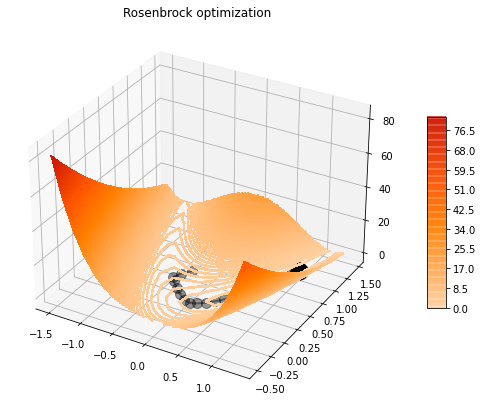

In [20]:
x = np.arange(-1.5, 1.5, 0.15)
y = np.arange(-0.5, 1.5, 0.15)
_, ax = contour_rosenbrock(x, y)

# Add optimization trajectory
steps = np.array(steps)
ax.plot(steps[::10, 0], steps[::10, 1], '.-k', lw=2, ms=20, alpha=0.4)
ax.scatter(1, 1, c='k', s=300)
ax.set_title('Rosenbrock optimization');

Now we try with 10 random starting directions

In [21]:
set_seed(42)
rosenbrock_torch = Rosenbrock()

attempts = []
for j in range(10):
    coords = 0.4 * torch.randn(1, 2)
    coords.requires_grad = True
    #optimizer = torch.optim.SGD([coords], lr=2e-2)
    optimizer = torch.optim.Adam([coords], lr=2e-2)
    steps = [coords.detach().numpy().copy().squeeze()]
    for i in range(500):
        optimizer.zero_grad()
        f = rosenbrock_torch(coords)
        f.backward()
        optimizer.step()
        steps.append(coords.detach().numpy().copy().squeeze())
    attempts.append(steps)

/opt/anaconda3/envs/mlcourse/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: The following kwargs were not used by contour: 'linewidth'


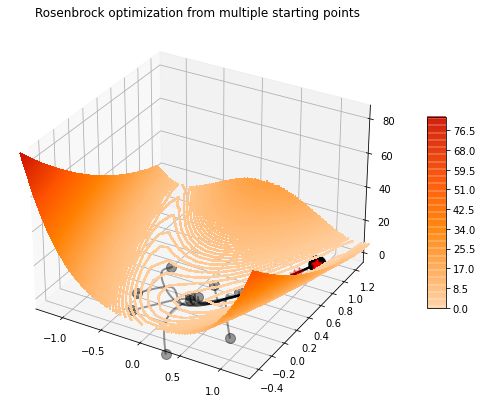

In [22]:
_, ax = contour_rosenbrock(x, y)

for a in attempts:
    steps_np = np.array(a)
    ax.plot(steps_np[:, 0], steps_np[:, 1], linewidth=2, c='k', alpha=0.4)
    ax.scatter(steps_np[0, 0], steps_np[0, 1], marker='o', color='k', s=100, alpha=0.40, zorder=100)
    ax.scatter(steps_np[-1, 0], steps_np[-1, 1], marker='*', color='r', s=100, alpha=0.4, zorder=100)
ax.scatter(1, 1, c='k', s=300)
ax.set_xlim(-1.3, 1.3)
ax.set_ylim(-0.5, 1.3)
ax.set_title('Rosenbrock optimization from multiple starting points');

**Exercise**: make similar plot but using different solvers (SGD, Adagrad, RMSProp, Adam) and see if they differ in terms of trajectories and convergence speed.

At this point, do not worry about the inner working each of the optimizers, we will look at them in details in coming weeks.

## Linear Regression

Up until now we said that PyTorch is a good framework if we wish to optimize (minimize/maximize) non-convex functions. 

Although not reccomended, we can however use it also for convex optimization. We are going to do this here to start familiarizing with PyTorch pre-implemented modules, which we will use later for basic and deep neural networks.  

Here we will use a simple linear module ``nn.Linear`` to perform linear regression of a dataset of points to which we have added some white gaussian noise.ion using gradient descent and pytorch's autograd functionality.

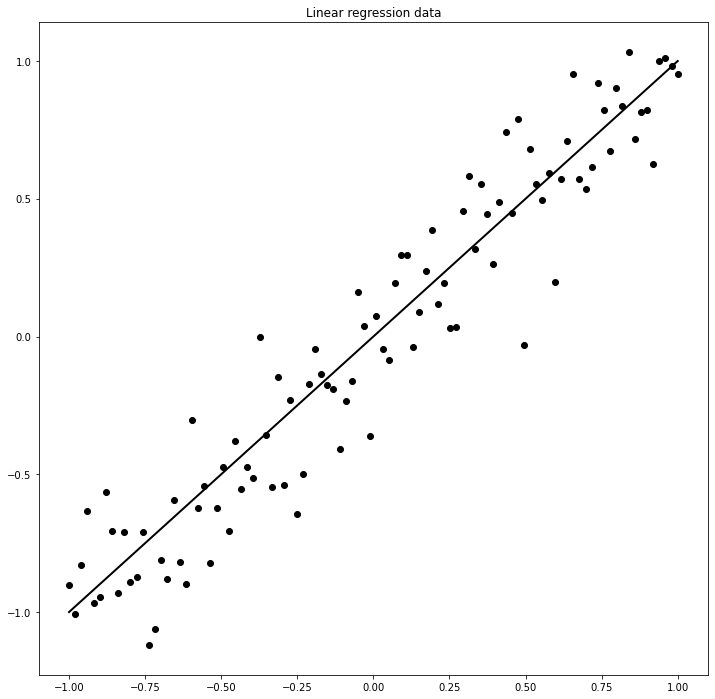

In [23]:
# Create dataset
set_seed(42)
a, b = 1., 0.
sigma = 0.2

x = np.linspace(-1, 1, 100)
n = np.random.normal(0, sigma, size=(100))
y = a * x + b + n

x, y = torch.from_numpy(x).float(), torch.from_numpy(y).float()

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.plot(x, x, 'k', lw=2)
ax.scatter(x, y, c='k')
ax.set_title('Linear regression data');

In [24]:
model = nn.Linear(1, 1, bias=True)
print(f'All parameters of a model {[(parameter.item(), parameter.size()) for parameter in model.parameters()]}')

optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss()
for epoch in range(100):
    total_loss = 0.
    for i, xp, yp in zip(range(len(x)), x, y):
        optimizer.zero_grad()
        yest = model(xp.view(1, 1)) 
        loss = criterion(yest, yp.view(1, 1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if epoch % 10 == 0 and epoch > 0:
        print(f'Epoch: {epoch}, Weight: {model.weight.data.item()}, Bias: {model.bias.data.item()}, Loss: {total_loss / x.size(0)}')

All parameters of a model [(0.7645385265350342, torch.Size([1, 1])), (0.8300079107284546, torch.Size([1]))]
Epoch: 10, Weight: 0.9088090062141418, Bias: 0.07611508667469025, Loss: 0.04823491021201334
Epoch: 20, Weight: 0.9624894261360168, Bias: -0.006417303346097469, Loss: 0.033887651274635576
Epoch: 30, Weight: 0.9884408116340637, Bias: -0.018315428867936134, Loss: 0.03292016863173558
Epoch: 40, Weight: 1.0014106035232544, Bias: -0.020305832847952843, Loss: 0.032735402432701906
Epoch: 50, Weight: 1.007952094078064, Bias: -0.02076912298798561, Loss: 0.03269193686595873
Epoch: 60, Weight: 1.0112605094909668, Bias: -0.020930208265781403, Loss: 0.03268198074139392
Epoch: 70, Weight: 1.0129340887069702, Bias: -0.021001823246479034, Loss: 0.03267999122171489
Epoch: 80, Weight: 1.013780117034912, Bias: -0.021036705002188683, Loss: 0.03267976764074319
Epoch: 90, Weight: 1.0142067670822144, Bias: -0.0210541021078825, Loss: 0.032679853838420175


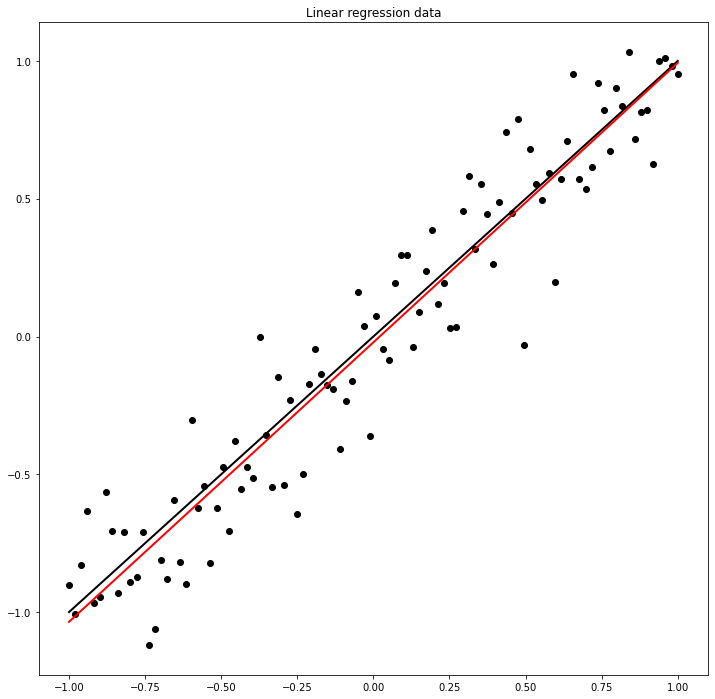

In [25]:
aest, best = model.weight.data.item(), model.bias.data.item()

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.plot(x, a * x + b, 'k', lw=2)
ax.plot(x, aest * x + best, 'r', lw=2)
ax.scatter(x, y, c='k')
ax.set_title('Linear regression data');

## Logistic regression

We will now use PyTorch to perform a simple Logistic regression for the so-called [Half-moon dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html). This is an interesting dataset as it is impossible to define a linear separation boundary between the two classes. 

First of all, let's visualize the dataset we will be using.

In [26]:
def make_train_test(train_size, test_size, noise=0.05):
    """
    Makes a two-moon train-test dataset
    """
    X_train, y_train = make_moons(n_samples=train_size, noise=noise)
    y_train = y_train.reshape(train_size, 1)
    X_train = X_train.reshape(train_size, 2)

    X_test, y_test = make_moons(n_samples=test_size, noise=0.1)
    y_test = y_test.reshape(test_size, 1)
    return X_train, y_train, X_test, y_test

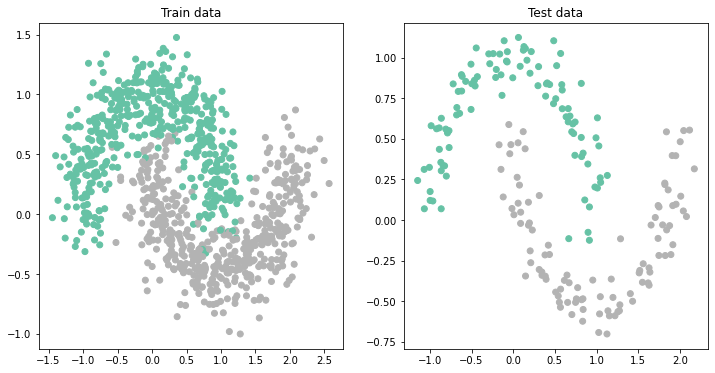

In [27]:
set_seed(42)

train_size = 1000 # Size of training data
test_size = 200 # Size of test data

X_train, y_train, X_test, y_test = make_train_test(train_size, test_size, noise=0.2)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='Set2')
ax[0].set_title('Train data')
ax[1].scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='Set2');
ax[1].set_title('Test data');

We proceed as follows the general workflow:

- 1. Define a Logistic Regression as a PyTorch ``nn.Module``
- 2. Setup the training function
- 3. Setup a validation/testing function
- 4. Create a training/validation/testing split of your data
- 5. Define the cost function
- 6. Iterate over your dataset (epoch) and train the network using the train() and validate() methods
- 7. Make Predictions on the training and test set and plot the results

We first create the ``LogisticRegression`` module like we have done already for the Rosebrock function

In [28]:
class LogisticRegression(nn.Module):
    def __init__(self, I, O):
        super(LogisticRegression, self).__init__()
        self.output = nn.Linear(I, O, bias=True)
        self.activation = nn.Sigmoid()
        
    def forward(self, x):
        z2 = self.output(x)
        a2 = self.activation(z2)
        return a2

We now setup the training and evaluation function, which are used to perform a single pass over all the data (i.e., epoch) of the entire training process. 

They are very similar in that they loop over the data and perform the following operations:

- apply the `model` and evaluation `criterion`
- (only training): apply backprop and make a step of the optimizer

At the end the prediction is made by looking if the returned value for each sample is smaller or bigger than 0.5. Finally we use the scikit-learn `accuracy_score` to compute the current accuracy of the model.

In [29]:
def train(model, criterion, optimizer, data_loader):
    model.train()
    loss = 0
    accuracy = 0
    for X, y in data_loader:
        optimizer.zero_grad()
        yprob = model(X)
        ls = criterion(yprob, y)
        ls.backward()
        optimizer.step()
        y_pred = np.where(yprob[:, 0].detach().numpy() > 0.5, 1, 0)
        loss += ls.item()
        accuracy += accuracy_score(y, y_pred)
    loss /= len(data_loader)
    accuracy /= len(data_loader)
    return loss, accuracy

In [30]:
def evaluate(model, criterion, data_loader):
    model.eval()
    loss = 0
    accuracy = 0
    for X, y in data_loader:
        with torch.no_grad(): # use no_grad to avoid making the computational graph...
            yprob = model(X)
            ls = criterion(yprob, y)
        y_pred = np.where(yprob[:, 0].numpy() > 0.5, 1, 0)
        loss += ls.item()
        accuracy += accuracy_score(y, y_pred)
    loss /= len(data_loader)
    accuracy /= len(data_loader)
    return loss, accuracy

Before we can train our model we need to prepare the input data (features and labels) such that they are PyTorch tensors. Moreover, we use PyTorch `DataLoader` functionality to load data in batches and return them during training. For simplicity we consider a single batch training here.

In [31]:
# Define Train Set
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

train_dataset = TensorDataset(X_train, y_train)

# Define Test Set
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

test_dataset = TensorDataset(X_test, y_test)

# Use Pytorch's functionality to load data in batches. Here we use full-batch training again.
train_loader = DataLoader(train_dataset, batch_size=X_train.size(0), shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=X_test.size(0), shuffle=False)

In [32]:
set_seed(42)

network = LogisticRegression(2, 1)
bce_loss = nn.BCELoss()
optim = torch.optim.SGD(network.parameters(), lr=1)

epochs = 1000
for i in range(epochs):
    train_loss, train_accuracy = train(network, bce_loss, optim, train_loader)
    test_loss, test_accuracy = evaluate(network, bce_loss, test_loader)
    
    if i % 100 == 0:
        print(f'Epoch {i}, Training Loss {train_loss:.2f}, Training Accuracy {train_accuracy:.2f}, Test Loss {test_loss:.2f}, Test Accuracy {test_accuracy:.2f}')

Epoch 0, Training Loss 0.70, Training Accuracy 0.47, Test Loss 0.63, Test Accuracy 0.56
Epoch 100, Training Loss 0.29, Training Accuracy 0.87, Test Loss 0.28, Test Accuracy 0.88
Epoch 200, Training Loss 0.29, Training Accuracy 0.87, Test Loss 0.27, Test Accuracy 0.89
Epoch 300, Training Loss 0.29, Training Accuracy 0.87, Test Loss 0.27, Test Accuracy 0.89
Epoch 400, Training Loss 0.29, Training Accuracy 0.87, Test Loss 0.27, Test Accuracy 0.89
Epoch 500, Training Loss 0.29, Training Accuracy 0.87, Test Loss 0.27, Test Accuracy 0.90
Epoch 600, Training Loss 0.29, Training Accuracy 0.87, Test Loss 0.27, Test Accuracy 0.90
Epoch 700, Training Loss 0.29, Training Accuracy 0.87, Test Loss 0.27, Test Accuracy 0.90
Epoch 800, Training Loss 0.29, Training Accuracy 0.87, Test Loss 0.27, Test Accuracy 0.90
Epoch 900, Training Loss 0.29, Training Accuracy 0.87, Test Loss 0.27, Test Accuracy 0.90


Test set accuracy:  0.895


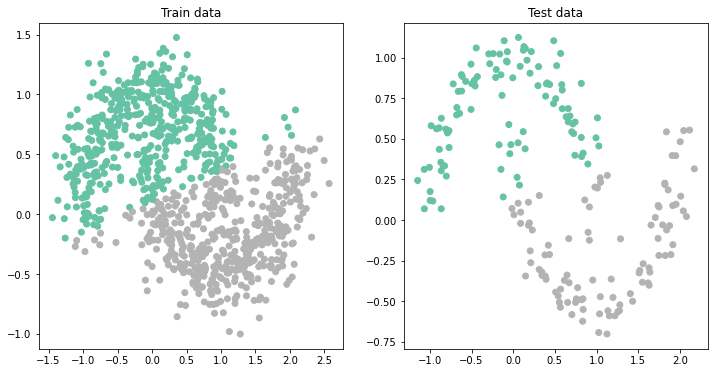

In [33]:
network.eval()
with torch.no_grad():
    a_train = network(X_train)
    a_test = network(X_test)
print("Test set accuracy: ", accuracy_score(y_test, np.where(a_test[:, 0].numpy()>0.5, 1, 0)))
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].scatter(X_train[:, 0], X_train[:, 1], c=np.where(a_train[:, 0].numpy()>0.5, 1, 0), cmap='Set2')
ax[0].set_title('Train data')
ax[1].scatter(X_test[:, 0], X_test[:, 1], c=np.where(a_test[:, 0].numpy()>0.5, 1, 0), cmap='Set2')
ax[1].set_title('Test data');

## Classification with NN

We don't seem to be able to get beyond 0.9 in our test accuracy with linear regression. This is because we are not able to create a nonlinear classification boundary.

Let's see if we can improve by using a Neural Network instead. The workflow is the similar, we define the new model and use the exact same training strategy.

In [34]:
class SingleHiddenLayerNetwork(nn.Module):
    def __init__(self, I, H, O):
        super(SingleHiddenLayerNetwork, self).__init__()
        self.hidden_1 = nn.Linear(I, H, bias=True)
        self.output = nn.Linear(H, O, bias=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        z1 = self.hidden_1(x)
        a1 = self.sigmoid(z1)
        z2 = self.output(a1)
        a2 = self.sigmoid(z2)
        return a2

In [35]:
set_seed(42)

network = SingleHiddenLayerNetwork(2, 8, 1)
bce_loss = nn.BCELoss()
optim = torch.optim.SGD(network.parameters(), lr=1)

for i in range(epochs):
    train_loss, train_accuracy = train(network, bce_loss, optim, train_loader)
    test_loss, test_accuracy = evaluate(network, bce_loss, test_loader)
    
    if i % 100 == 0:
        print(f'Epoch {i}, Training Loss {train_loss:.2f}, Training Accuracy {train_accuracy:.2f}, Test Loss {test_loss:.2f}, Test Accuracy {test_accuracy:.2f}')

Epoch 0, Training Loss 0.70, Training Accuracy 0.50, Test Loss 0.67, Test Accuracy 0.86
Epoch 100, Training Loss 0.30, Training Accuracy 0.87, Test Loss 0.28, Test Accuracy 0.88
Epoch 200, Training Loss 0.29, Training Accuracy 0.87, Test Loss 0.27, Test Accuracy 0.90
Epoch 300, Training Loss 0.29, Training Accuracy 0.87, Test Loss 0.27, Test Accuracy 0.90
Epoch 400, Training Loss 0.29, Training Accuracy 0.87, Test Loss 0.27, Test Accuracy 0.90
Epoch 500, Training Loss 0.29, Training Accuracy 0.87, Test Loss 0.27, Test Accuracy 0.90
Epoch 600, Training Loss 0.29, Training Accuracy 0.87, Test Loss 0.27, Test Accuracy 0.90
Epoch 700, Training Loss 0.29, Training Accuracy 0.87, Test Loss 0.27, Test Accuracy 0.90
Epoch 800, Training Loss 0.29, Training Accuracy 0.87, Test Loss 0.27, Test Accuracy 0.90
Epoch 900, Training Loss 0.29, Training Accuracy 0.87, Test Loss 0.27, Test Accuracy 0.90


Test set accuracy:  0.895


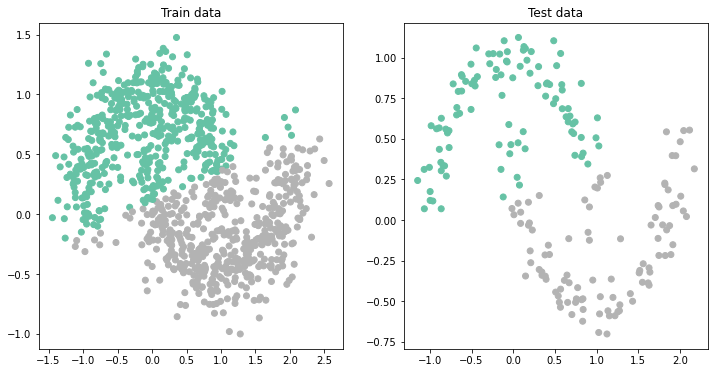

In [36]:
network.eval()
with torch.no_grad():
    a_train = network(X_train)
    a_test = network(X_test)
print("Test set accuracy: ", accuracy_score(y_test, np.where(a_test[:, 0].numpy()>0.5, 1, 0)))

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].scatter(X_train[:, 0], X_train[:, 1], c=np.where(a_train[:, 0].numpy()>0.5, 1, 0), cmap='Set2')
ax[0].set_title('Train data')
ax[1].scatter(X_test[:, 0], X_test[:, 1], c=np.where(a_test[:, 0].numpy()>0.5, 1, 0), cmap='Set2')
ax[1].set_title('Test data');

Nothing better. Why?

This is where lies the difference between using a Neural Network versus taking full advantage of it. 
Let's change the model a bit and make it deeper

In [37]:
class DeepNetwork(nn.Module):
    def __init__(self, I, H, O):
        super(DeepNetwork, self).__init__()
        self.hidden_1 = nn.Linear(I, H[0], bias=True)
        self.hidden_2 = nn.Linear(H[0], H[1], bias=True)
        self.output = nn.Linear(H[1], O, bias=True)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        z1 = self.hidden_1(x)
        a1 = self.relu(z1)
        z2 = self.hidden_2(a1)
        a2 = self.relu(z2)
        z3 = self.output(a2)
        a3 = self.sigmoid(z3)
        return a3

In [38]:
set_seed(42)

network = DeepNetwork(2, [4, 8], 1)

# Another option to create sequential models (more compact!)
#network = nn.Sequential(nn.Linear(2, 4, bias=True), 
#                        nn.ReLU(),
#                        nn.Linear(4, 8, bias=True), 
#                        nn.ReLU(),
#                        nn.Linear(8, 1, bias=True),
#                        nn.Sigmoid())

bce_loss = nn.BCELoss()
optim = torch.optim.SGD(network.parameters(), lr=1.)

for i in range(epochs):
    train_loss, train_accuracy = train(network, bce_loss, optim, train_loader)
    test_loss, test_accuracy = evaluate(network, bce_loss, test_loader)
    
    if i % 100 == 0:
        print(f'Epoch {i}, Training Loss {train_loss:.2f}, Training Accuracy {train_accuracy:.2f}, Test Loss {test_loss:.2f}, Test Accuracy {test_accuracy:.2f}')

Epoch 0, Training Loss 0.68, Training Accuracy 0.50, Test Loss 0.67, Test Accuracy 0.50
Epoch 100, Training Loss 0.33, Training Accuracy 0.86, Test Loss 0.33, Test Accuracy 0.85
Epoch 200, Training Loss 0.13, Training Accuracy 0.95, Test Loss 0.07, Test Accuracy 0.98
Epoch 300, Training Loss 0.09, Training Accuracy 0.96, Test Loss 0.03, Test Accuracy 0.99
Epoch 400, Training Loss 0.08, Training Accuracy 0.97, Test Loss 0.03, Test Accuracy 0.99
Epoch 500, Training Loss 0.09, Training Accuracy 0.97, Test Loss 0.03, Test Accuracy 0.99
Epoch 600, Training Loss 0.07, Training Accuracy 0.97, Test Loss 0.02, Test Accuracy 0.99
Epoch 700, Training Loss 0.08, Training Accuracy 0.97, Test Loss 0.02, Test Accuracy 0.99
Epoch 800, Training Loss 0.08, Training Accuracy 0.97, Test Loss 0.03, Test Accuracy 0.99
Epoch 900, Training Loss 0.07, Training Accuracy 0.97, Test Loss 0.02, Test Accuracy 0.99


Test set accuracy:  0.99


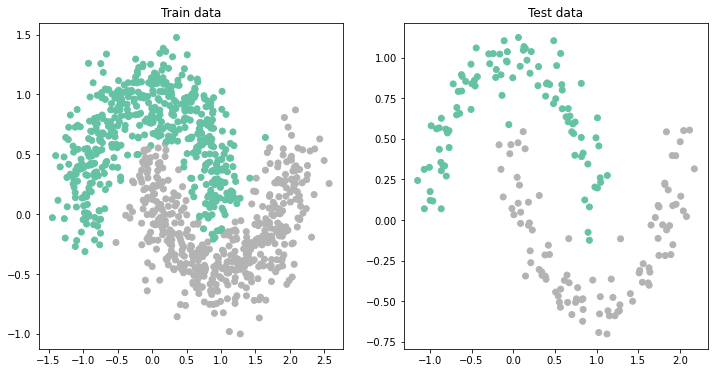

In [39]:
network.eval()
with torch.no_grad():
    a_train = network(X_train)
    a_test = network(X_test)
print("Test set accuracy: ", accuracy_score(y_test, np.where(a_test[:, 0].numpy()>0.5, 1, 0)))

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].scatter(X_train[:, 0], X_train[:, 1], c=np.where(a_train[:, 0].numpy()>0.5, 1, 0), cmap='Set2')
ax[0].set_title('Train data')
ax[1].scatter(X_test[:, 0], X_test[:, 1], c=np.where(a_test[:, 0].numpy()>0.5, 1, 0), cmap='Set2')
ax[1].set_title('Test data');

BUT, is it really true that we needed a deeper network to be able to get better accuracy?

In [40]:
class SingleHiddenLayerNetwork(nn.Module):
    def __init__(self, I, H, O):
        super(SingleHiddenLayerNetwork, self).__init__()
        self.hidden_1 = nn.Linear(I, H, bias=True)
        self.output = nn.Linear(H, O, bias=True)
        self.sigmoid = nn.Sigmoid()
        # Add relu
        self.relu = nn.ReLU()
        
    def forward(self, x):
        z1 = self.hidden_1(x)
        a1 = self.relu(z1) # use relu
        z2 = self.output(a1)
        a2 = self.sigmoid(z2)
        return a2

In [41]:
set_seed(42)

network = SingleHiddenLayerNetwork(2, 8, 1)
bce_loss = nn.BCELoss()
optim = torch.optim.SGD(network.parameters(), lr=1)

for i in range(epochs):
    train_loss, train_accuracy = train(network, bce_loss, optim, train_loader)
    test_loss, test_accuracy = evaluate(network, bce_loss, test_loader)
    
    if i % 100 == 0:
        print(f'Epoch {i}, Training Loss {train_loss:.2f}, Training Accuracy {train_accuracy:.2f}, Test Loss {test_loss:.2f}, Test Accuracy {test_accuracy:.2f}')

Epoch 0, Training Loss 0.72, Training Accuracy 0.47, Test Loss 0.61, Test Accuracy 0.85
Epoch 100, Training Loss 0.26, Training Accuracy 0.88, Test Loss 0.24, Test Accuracy 0.90
Epoch 200, Training Loss 0.18, Training Accuracy 0.93, Test Loss 0.14, Test Accuracy 0.94
Epoch 300, Training Loss 0.14, Training Accuracy 0.95, Test Loss 0.10, Test Accuracy 0.97
Epoch 400, Training Loss 0.11, Training Accuracy 0.96, Test Loss 0.07, Test Accuracy 0.98
Epoch 500, Training Loss 0.10, Training Accuracy 0.97, Test Loss 0.06, Test Accuracy 0.98
Epoch 600, Training Loss 0.09, Training Accuracy 0.97, Test Loss 0.05, Test Accuracy 0.98
Epoch 700, Training Loss 0.08, Training Accuracy 0.97, Test Loss 0.04, Test Accuracy 0.98
Epoch 800, Training Loss 0.08, Training Accuracy 0.97, Test Loss 0.04, Test Accuracy 0.98
Epoch 900, Training Loss 0.08, Training Accuracy 0.97, Test Loss 0.04, Test Accuracy 0.98


Test set accuracy:  0.985


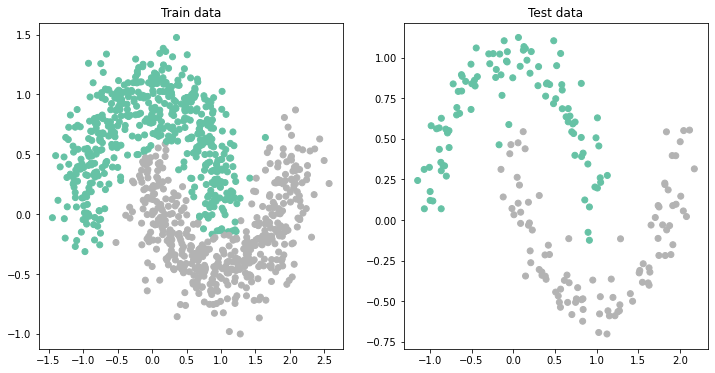

In [42]:
network.eval()
with torch.no_grad():
    a_train = network(X_train)
    a_test = network(X_test)
print("Test set accuracy: ", accuracy_score(y_test, np.where(a_test[:, 0].numpy()>0.5, 1, 0)))

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].scatter(X_train[:, 0], X_train[:, 1], c=np.where(a_train[:, 0].numpy()>0.5, 1, 0), cmap='Set2')
ax[0].set_title('Train data')
ax[1].scatter(X_test[:, 0], X_test[:, 1], c=np.where(a_test[:, 0].numpy()>0.5, 1, 0), cmap='Set2')
ax[1].set_title('Test data');

This is something you should learn since day 1!!! The solution to every problem is not making your network deeper. Sometimes small changes to the network in terms of activation functions, width of layers, etc. can make as much difference as making the network deeper (so harder to train)

That's it! We have just scratched the surface of what PyTorch has to offer but we are now able to:

- Optimize nonlinear functionals with PyTorch backprop + optimizers;
- Perform Linear Regression;
- Perform Logistic Regression;
- Improve upon the accuracy of Logistic Regression using a Neural Network.

In [43]:
scooby.Report(core='torch')

--------------------------------------------------------------------------------
  Date: Thu Jan 19 18:17:20 2023 +03

                OS : Darwin
            CPU(s) : 10
           Machine : x86_64
      Architecture : 64bit
               RAM : 16.0 GiB
       Environment : Jupyter
       File system : apfs

  Python 3.7.13 (default, Mar 28 2022, 07:24:34)  [Clang 12.0.0 ]

             torch : 1.8.1
             numpy : 1.21.5
             scipy : 1.7.3
           IPython : 7.31.1
        matplotlib : 3.5.1
            scooby : 0.5.12

  Intel(R) oneAPI Math Kernel Library Version 2021.4-Product Build 20210904
  for Intel(R) 64 architecture applications
--------------------------------------------------------------------------------